### <목차>
 
**Step 1. 데이터 수집하기**
  - 1.1 라이브러리 가져오기 (불용어 사전NLTK패키지도 함께 가져오기)
  - 1.2 Data set 확인

**Step 2. 데이터 전처리하기 (추상적 요약)**
  - 2.1 중복과 NULL값 정리
  - 2.1 중복과 NULL값 정리
  - 2.2 불용어 정리 함수 만들기
  - 2.3 'text', 'headlines' 컬럼 데이터 전처리하기
  - 2.4 샘플 최대 길이 정하기
  - 2.5 headlines컬럼 데이터에 SOS, EOS 토큰 붙이기
  - 2.6 2.6 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
  - 2.7 test, val 나누기
  - 2.8 단어 집합(text, headlines)만들고 요악문 정리(삭제, 패딩)

**Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**
  - 3.1 모델 설계하기
  - 3.2 모델 훈련하기
  - 3.3 학습 결과 시각화 (train loss vs. val loss)
  - 3.4 인퍼런스모델 구현하기

**Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)**
  - 모델 테스트하기

**Step 5. Summa을 이용해서 추출적 요약해보기**
  - Summa의 summarize를 사용하여 추출적 요약 실행
  - 표로 비교하기(추상적 vs. 추출적 요약)


회고 :   
중간에 어탠션 모델을 설계하는 부분이 빠져서, 모델을 수정하다가 끝까지 못돌린게 아쉽습니다.  

---

## **Step 1. 데이터 수집하기**
  - text를 본문으로, headline을 summary 데이터로 사용

**1.1 라이브러리 가져오기 (불용어 사전NLTK패키지도 함께 가져오기)**

In [71]:
import nltk
nltk.download('stopwords') # 불용어 사전 

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1.2 Data set 확인**

In [72]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/AIFFEL_quest_rs/AIFFEL_quest_rs/Exploration/Ex06/news_summary_more.csv", nrows=100000)
data_org = data.copy()
print('전체 샘플수 :', (len(data_org)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
59229,Cat hair help identify woman who mailed explos...,The person who mailed an improvised explosive ...
13140,3 children buried alive while digging soil in ...,"Three cousins, aged between 10 and 15 years, w..."
18739,Uber driver accused of kicking blind woman out...,A blind woman from Brazil has claimed she was ...
68902,Lehman Brothers to sell Formula One stake for ...,Bankrupt Lehman Brothers has announced the sal...
34235,Middle East Uber rival Careem reveals 14M user...,"Uber rival Careem, a ride-hail startup based i..."
86996,"1 killed, 5 injured in military plane crash in...",A Russian serviceman was killed and five other...
61155,Telangana cop suspended over massage from fema...,Assistant Sub-Inspector Hasan from Telangana's...
91401,Sourav Ganguly denies creating Dhoni-less IPL ...,Former India captain Sourav Ganguly has denied...
24432,Petition asks Disney to hire director fired fo...,"Over 2 lakh people have signed a petition, add..."
83777,No evidence of any irregularities in Panaya de...,Infosys on Friday said its internal audit comm...


## **Step 2. 데이터 전처리하기 (추상적 요약)**

**2.1 중복과 NULL값 정리**

In [73]:
# 중복값 정리
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수(중복값정리 전) :', (len(data_org)))
print('전체 샘플수(중복값정리 후) :', (len(data)))

전체 샘플수(중복값정리 전) : 98401
전체 샘플수(중복값정리 후) : 98360


In [74]:
# NULL 값 정리
print(data.isnull().sum())
print('\n', '=> NULL정리할 것이 없음을 확인함')

headlines    0
text         0
dtype: int64

 => NULL정리할 것이 없음을 확인함


**2.2 불용어 정리 함수 만들기**

In [75]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))
# print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179


In [76]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [77]:
# 함수 잘 만들어졌나 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.
print("summary:", preprocess_sentence(temp_summary, True))   # 불용어를 제거합니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day
summary: great way start day


**2.3 'text', 'headlines' 컬럼 데이터 전처리하기**

In [78]:
# 전체 text 데이터에 대한 전처리 
clean_text = []

# 반복문으로 사용자정의 함수 사용하여 불용어 제거하기
for x in data['text']:
    clean_text.append(preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [79]:
# 전체 headlines 데이터에 대한 전처리  
clean_summary = []

# 반복문으로 사용자정의 함수 사용하여 불용어 제거하기
for y in data['headlines']:
    clean_summary.append(preprocess_sentence(y,False))
    
# 전처리 후 출력
print("Headlines 전처리 후 결과: ", clean_summary[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


**(혹시나 있을 빈 값을 NULL로 변환)**

In [80]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [81]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

**2.4 샘플 최대 길이 정하기**

In [82]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


2.4.1 시각화하기

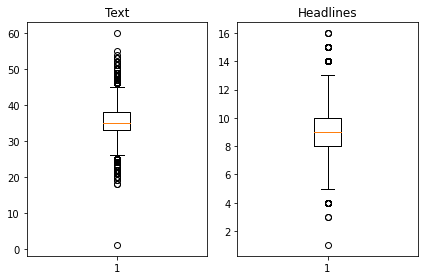

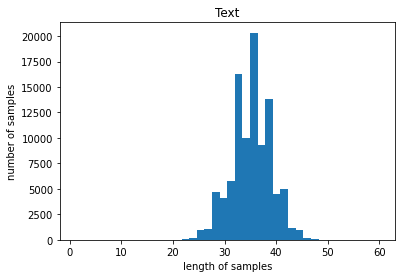

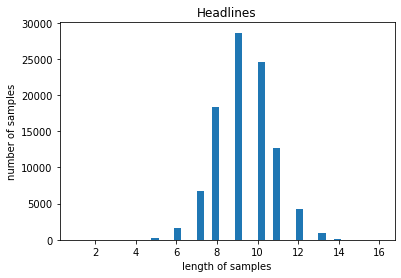

In [83]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**2.4.3 최대값 정하기**

In [84]:
text_max_len = 50
summary_max_len = 12 # 11, 10 , 8

In [85]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [86]:
# below_threshold_len(text_max_len, data['text'])
# below_threshold_len(summary_max_len,  data['headlines'])

In [87]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [88]:
filtered_data = data[
        data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= summary_max_len, axis=1)
    ]


print('원본 샘플수 :', (len(data_org)))
print('전체 샘플수 :', (len(data)))

원본 샘플수 : 98401
전체 샘플수 : 98360


**2.5 headlines컬럼 데이터에 SOS, EOS 토큰 붙이기**

In [89]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


**2.6 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장**

In [90]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

**2.7 test, val 나누기**

encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다

In [91]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[29704 29320 28640 ... 32004 11776 19627]


In [92]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플을 만듦

In [93]:
# TRAIN, VAL, TEST
n_of_trn = int(len(encoder_input)*0.5)
n_of_val = int(len(encoder_input)*0.3)
n_of_tst = int(len(encoder_input)*0.2)

print('훈련 데이터의 수 :', n_of_trn)
print('검증 데이터의 수 :', n_of_val)
print('테스트 데이터의 수 :', n_of_tst)
print(n_of_trn+n_of_val+n_of_tst)

훈련 데이터의 수 : 49180
검증 데이터의 수 : 29508
테스트 데이터의 수 : 19672
98360


위에 나눈 비율 (5:3:2)로 TRAIN, VAL, TEST 데이터 나누기

In [94]:
# TRAIN 데이터 나누기
encoder_input_train = encoder_input[0:49180]
decoder_input_train = decoder_input[0:49180]
decoder_target_train = decoder_target[0:49180]
# VAL
encoder_input_val= encoder_input[49180:78688]
decoder_input_val= decoder_input[49180:78688]
decoder_target_val = decoder_target[49180:78688]
# TEST 
encoder_input_test = encoder_input[78688:]
decoder_input_test = decoder_input[78688:]
decoder_target_test = decoder_target[78688:]

In [95]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

print('검증 데이터의 개수 :', len(encoder_input_val))
print('검증 레이블의 개수 :', len(decoder_input_val))

print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 49180
훈련 레이블의 개수 : 49180
검증 데이터의 개수 : 29508
검증 레이블의 개수 : 29508
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


**2.8 단어 집합 만들기**

**2.8.1 단어 집합 : text**

In [96]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [97]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57387
등장 빈도가 4번 이하인 희귀 단어의 수: 36074
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21313
단어 집합에서 희귀 단어의 비율: 62.860926690713924
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5769288264516823


In [98]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한

In [99]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[22, 715, 1196, 14, 688, 1719, 149, 14, 6953, 233, 542, 599, 985, 2723, 1093, 1222, 899, 233, 599, 273, 2724, 105, 6953, 888, 1719, 7246, 1093, 1222, 1139, 2516, 151, 14], [49, 110, 43, 89, 3114, 3451, 5290, 2, 7, 1402, 1744, 2310, 543, 828, 579, 18, 625, 5290, 2015, 1291, 968, 4627, 262, 1340, 35, 175, 19, 257, 310, 230, 5290, 115, 209, 184, 4361], [361, 249, 193, 698, 452, 6573, 5136, 62, 689, 798, 1057, 1325, 2501, 1, 280, 658, 2411, 39, 145, 1193, 5447, 802, 3186, 689, 37, 6107, 3515, 3611, 2993, 1, 1135, 1164, 768]]


**2.8.2 단어 집합 : headlines**

In [100]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # headlines

In [101]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25424
등장 빈도가 4번 이하인 희귀 단어의 수: 16358
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9066
단어 집합에서 희귀 단어의 비율: 64.34078036500944
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.505414806129016


In [102]:
'''tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)

tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
'''

'tar_vocab = 2000\ntar_tokenizer = Tokenizer(num_words=tar_vocab) \ntar_tokenizer.fit_on_texts(decoder_input_train)\n\ntar_tokenizer.fit_on_texts(decoder_target_train)\n\n# 텍스트 시퀀스를 정수 시퀀스로 변환\ndecoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) \ndecoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)\n\ndecoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)\ndecoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)\n\ndecoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)\ndecoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)\n'

In [103]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)

tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


**^^^^ 위 AttributeError는 정수 변환이후 재실행하며 일어난 오류 ^^^^**


In [104]:
# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 870, 80, 417, 3, 744, 15, 483, 407, 7, 361], [1, 22, 35, 44, 1015, 1503, 3, 18, 1167], [1, 139, 955, 3, 871, 7, 1781], [1, 4, 671, 4, 198, 250], [1, 94, 1052, 1678, 9, 1066, 402, 157, 79, 29]]
target
decoder  [[870, 80, 417, 3, 744, 15, 483, 407, 7, 361, 2], [22, 35, 44, 1015, 1503, 3, 18, 1167, 2], [139, 955, 3, 871, 7, 1781, 2], [4, 671, 4, 198, 250, 2], [94, 1052, 1678, 9, 1066, 402, 157, 79, 29, 2]]


**2.8.3 요약문 길이 1인 경우, 삭제**  
이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [105]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_val = [index for index, sentence in enumerate(decoder_input_val) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_val))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_val = [sentence for index, sentence in enumerate(encoder_input_val) if index not in drop_val]
decoder_input_val = [sentence for index, sentence in enumerate(decoder_input_val) if index not in drop_val]
decoder_target_val = [sentence for index, sentence in enumerate(decoder_target_val) if index not in drop_val]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_val))
print('검증 레이블의 개수 :', len(decoder_input_val))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 7
삭제할 테스트 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 49173
훈련 레이블의 개수 : 49173
검증 데이터의 개수 : 29506
검증 레이블의 개수 : 29506
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


**2.8.4 패딩하기**

In [106]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train  = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

decoder_input_val  = pad_sequences(decoder_input_val, maxlen=summary_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=summary_max_len, padding='post')

decoder_input_test  = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## **Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**

  - 3.1 모델 설계하기

In [107]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [108]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
x = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb)
x = encoder_lstm2(x)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
# encoder_output3, state_h3, state_c3 = encoder_lstm3(enc_emb)
encoder_output, state_h, state_c = encoder_lstm3(x)

In [109]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [110]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [111]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output1])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "embedding". The following previous layers were accessed without issue: ['embedding_3', 'lstm_7', 'lstm_8']

  - 3.2 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val), \
          batch_size=256, callbacks=[es], epochs=50)

  - 3.3 학습 결과 시각화 (train loss vs. val loss)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

  - 3.4 인퍼런스모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

**Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)**

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0) and (i != tar_word_to_index['sostoken']) and (i != tar_word_to_index['eostoken'])):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

**Step 5. Summa을 이용해서 추출적 요약해보기**

  - Summa의 summarize를 사용하여 추출적 요약 실행

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

  - 표로 비교하기(추상적 vs. 추출적 요약)

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, words=100, split=True)